In [ ]:
import sys
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from tdsc_abus2023_pytorch import TDSC, DataSplits, ViewTransformer, ViewTransposeConfig

sys.path.append("../")
import abus_classification

Dataset already exists in: ../data/tdsc/Train
Dataset already exists in: ../data/tdsc/Test
Dataset already exists in: ../data/tdsc/Validation


Malignant
(608, 330, 865)


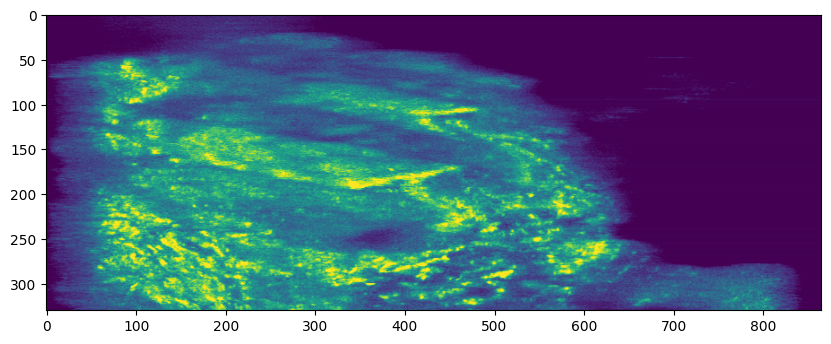

In [4]:
saggital_transform = ViewTransformer(view=ViewTransposeConfig.CORONAL)

train_data = TDSC(path="../data/tdsc", split=DataSplits.TRAIN, transforms=[saggital_transform],download=True)
test_data = TDSC(path="../data/tdsc", split=DataSplits.TEST, transforms=[saggital_transform], download=True)
validation_data = TDSC(path="../data/tdsc", split=DataSplits.VALIDATION, transforms=[saggital_transform], download=True)

volume, mask, label, bbx = train_data[0]

print(train_data.class_names[label])

print(volume.shape)
random_slice = volume[300]

plt.figure(figsize=(10,10))
plt.imshow(random_slice)
plt.show()

## Calculating distances to the center

In [19]:
def find_shape_center(volume_mask, use_mesh=True):
    """
    Calculate the center (centroid) of a binary 3D mask representing a tumor segmentation.
    The center is calculated from the mesh surface points (boundary vertices).
    
    Parameters:
    -----------
    volume_mask : ndarray
        Binary numpy array where 1 values represent the tumor segmentation (0 = background)
    use_mesh : bool, default=True
        If True, uses mesh surface points to calculate center.
        If False, uses all voxel coordinates (legacy method).
        
    Returns:
    --------
    tuple : (x, y, z) coordinates of the center
    """
    if use_mesh:
        # Get boundary points from mesh surface
        boundary_points = get_boundary_points(volume_mask, use_mesh=True)
        
        if len(boundary_points) > 0:
            # Calculate centroid of surface points
            x = np.mean(boundary_points[:, 0])
            y = np.mean(boundary_points[:, 1])
            z = np.mean(boundary_points[:, 2])
        else:
            # Fallback to volume center if no boundary points
            x = volume_mask.shape[0] / 2
            y = volume_mask.shape[1] / 2
            z = volume_mask.shape[2] / 2
    else:
        # Legacy method: use all voxel coordinates
        coords = np.where(volume_mask == 1)
        
        if len(coords[0]) > 0:
            x = np.mean(coords[0])
            y = np.mean(coords[1])
            z = np.mean(coords[2])
        else:
            # If mask is empty, return center of the volume
            x = volume_mask.shape[0] / 2
            y = volume_mask.shape[1] / 2
            z = volume_mask.shape[2] / 2
    
    return x, y, z

def get_boundary_points(volume_mask, use_mesh=True):
    """
    Get all points on the boundary of a 3D tumor mask.
    
    Parameters:
    -----------
    volume_mask : ndarray
        Binary numpy array where 1 values represent the tumor segmentation (0 = background)
    use_mesh : bool, default=True
        If True, uses marching cubes to create a mesh and extract surface vertices.
        If False, uses erosion-based method (voxel-based boundary).
        
    Returns:
    --------
    ndarray : Array of shape (N, 3) containing (x, y, z) coordinates of all boundary points
    """
    if use_mesh:
        try:
            from skimage import measure
            # Use marching cubes to create a mesh from the binary mask
            # This gives a proper surface representation
            verts, faces, normals, values = measure.marching_cubes(
                volume_mask.astype(float), 
                level=0.5,  # threshold for binary mask
                spacing=(1.0, 1.0, 1.0)  # voxel spacing (adjust if needed)
            )
            # Return unique vertices (marching cubes may have duplicates)
            # Vertices are the surface points
            return verts
        except ImportError:
            print("skimage not available, falling back to erosion method")
            use_mesh = False
    
    if not use_mesh:
        # Fallback: erosion-based method
        from scipy.ndimage import binary_erosion
        
        # Create a 6-connected structure (face neighbors only)
        structure = np.zeros((3, 3, 3), dtype=np.uint8)
        structure[1, 1, 1] = 1  # center
        structure[1, 1, 0] = 1  # front
        structure[1, 1, 2] = 1  # back
        structure[1, 0, 1] = 1  # top
        structure[1, 2, 1] = 1  # bottom
        structure[0, 1, 1] = 1  # left
        structure[2, 1, 1] = 1  # right
        
        # Erode the mask - this removes boundary points
        eroded = binary_erosion(volume_mask == 1, structure=structure).astype(np.uint8)
        
        # Boundary is the difference between original and eroded
        boundary_mask = (volume_mask == 1).astype(np.uint8) - eroded
        
        # Get all boundary point coordinates
        coords = np.where(boundary_mask == 1)
        
        if len(coords[0]) > 0:
            # Stack coordinates into (N, 3) array
            boundary_points = np.column_stack((coords[0], coords[1], coords[2]))
        else:
            boundary_points = np.empty((0, 3), dtype=np.int32)
        
        return boundary_points

def get_boundary_mesh(volume_mask):
    """
    Convert a binary 3D mask to a trimesh object.
    
    Parameters:
    -----------
    volume_mask : ndarray
        Binary numpy array where 1 values represent the tumor segmentation (0 = background)
        
    Returns:
    --------
    trimesh.Trimesh or dict : Mesh object (if trimesh available) or dict with vertices and faces
    """
    try:
        from skimage import measure
        
        # Use marching cubes to create a mesh
        verts, faces, normals, values = measure.marching_cubes(
            volume_mask.astype(float),
            level=0.5,
            spacing=(1.0, 1.0, 1.0)
        )
        
        try:
            import trimesh
            # Create trimesh object
            mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)
            return mesh
        except ImportError:
            # Return as dict if trimesh not available
            return {'vertices': verts, 'faces': faces, 'normals': normals}
            
    except ImportError:
        raise ImportError("skimage is required for mesh conversion. Install with: pip install scikit-image")

def visualize_mesh_with_center(volume_mask, center=None, point_radius=1.0, num_rays=10):
    """
    Visualize the 3D mesh with the center point marked in red using trimesh.
    Shows rays (lines) from the center to random boundary points.
    
    Parameters:
    -----------
    volume_mask : ndarray
        Binary numpy array where 1 values represent the tumor segmentation (0 = background)
    center : tuple or None, default=None
        Center point (x, y, z). If None, will be calculated using find_shape_center.
    point_radius : float, default=1.0
        Radius of the center point sphere
    num_rays : int, default=10
        Number of random rays to display from center to boundary
        
    Returns:
    --------
    trimesh.Scene : The scene object (call .show() to display)
    """
    try:
        import trimesh
    except ImportError:
        raise ImportError("trimesh is required for visualization. Install with: pip install trimesh")
    
    # Get mesh
    mesh = get_boundary_mesh(volume_mask)
    
    # If it's a dict, convert to trimesh
    if isinstance(mesh, dict):
        mesh = trimesh.Trimesh(vertices=mesh['vertices'], 
                              faces=mesh['faces'], 
                              vertex_normals=mesh['normals'])
    
    # Calculate center if not provided
    if center is None:
        center = find_shape_center(volume_mask, use_mesh=True)
    
    center = np.array(center)
    
    # Get boundary points
    boundary_points = get_boundary_points(volume_mask, use_mesh=True)
    
    # Create a sphere at the center point
    center_sphere = trimesh.creation.icosphere(subdivisions=2, radius=point_radius)
    center_sphere.apply_translation(center)
    center_sphere.visual.face_colors = [255, 0, 0, 255]  # Red color
    
    # Create rays from center to random boundary points
    scene_objects = [mesh, center_sphere]
    
    if len(boundary_points) > 0:
        # Randomly sample boundary points
        num_samples = min(num_rays, len(boundary_points))
        np.random.seed(42)  # For reproducibility
        sampled_indices = np.random.choice(len(boundary_points), num_samples, replace=False)
        sampled_boundary_points = boundary_points[sampled_indices]
        
        # Create line segments for each ray
        for boundary_point in sampled_boundary_points:
            # Create a thin cylinder to represent the ray from center to boundary
            direction = boundary_point - center
            distance = np.linalg.norm(direction)
            if distance > 0:
                # Create a thin cylinder along the ray
                ray_cylinder = trimesh.creation.cylinder(radius=0.1, height=distance)
                # Rotate cylinder to align with direction
                direction_normalized = direction / distance
                # Calculate rotation to align z-axis with direction
                z_axis = np.array([0, 0, 1])
                if not np.allclose(direction_normalized, z_axis):
                    # Calculate rotation axis and angle
                    rotation_axis = np.cross(z_axis, direction_normalized)
                    if np.linalg.norm(rotation_axis) > 1e-6:
                        rotation_axis = rotation_axis / np.linalg.norm(rotation_axis)
                        rotation_angle = np.arccos(np.clip(np.dot(z_axis, direction_normalized), -1, 1))
                        rotation_matrix = trimesh.transformations.rotation_matrix(
                            rotation_angle, rotation_axis
                        )
                        ray_cylinder.apply_transform(rotation_matrix)
                # Translate to start from center (cylinder center is at origin, so translate by half distance)
                ray_cylinder.apply_translation(center + direction / 2)
                ray_cylinder.visual.face_colors = [255, 255, 0, 200]  # Yellow with transparency
                scene_objects.append(ray_cylinder)
    
    # Create scene with mesh, center point, and rays
    scene = trimesh.Scene(scene_objects)
    
    return scene

vol, mask, label, bbx = train_data[1]
shape_center = find_shape_center(mask)
print(shape_center)

scene = visualize_mesh_with_center(mask, center=shape_center)
scene.show()

(np.float32(116.54884), np.float32(110.66947), np.float32(689.54596))


In [ ]:


for _, mask, label, _ in train_data:
    center = find_shape_center(mask)
    boundary_points = get_boundary_points(mask)
    
    # Convert boundary points to relative coordinates (centered at origin)
    relative_points = boundary_points - center
    
    # Calculate r: distance from center to boundary point
    r = np.linalg.norm(relative_points, axis=1)
    
    # Calculate alpha: azimuthal angle in xy-plane (0 to 2π)
    # This is the angle measured from the positive x-axis
    alpha = np.arctan2(relative_points[:, 1], relative_points[:, 0])
    
    # Calculate beta: polar angle from z-axis (0 to π)
    # This is the angle measured from the positive z-axis
    # beta = arccos(z / r) where z is the z-component and r is the distance
    z_components = relative_points[:, 2]
    # Avoid division by zero for points at the center
    beta = np.arccos(np.clip(z_components / r, -1.0, 1.0))
    


1.710676908493042
3.047036647796631


In [12]:
def train_svm_and_get_metrics(X_train, y_train, X_test, y_test, **svm_params):
    """
    Train an SVM classifier and return comprehensive test metrics.
    
    Parameters:
    -----------
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
    **svm_params : dict
        Additional parameters to pass to SVC (e.g., kernel='rbf', C=1.0, gamma='scale')
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'accuracy': Test accuracy
        - 'precision': Precision score (macro and per-class)
        - 'recall': Recall score (macro and per-class)
        - 'f1_score': F1 score (macro and per-class)
        - 'confusion_matrix': Confusion matrix
        - 'classification_report': Text classification report
        - 'train_accuracy': Training accuracy
        - 'model': Trained SVM model
    """
    # Initialize SVM with provided parameters (defaults to RBF kernel)
    clf = SVC(**svm_params)
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Get unique labels for per-class metrics
    labels = np.unique(np.concatenate([y_train, y_test]))
    
    precision = precision_score(y_test, y_test_pred, labels=labels, average=None, zero_division=0)
    precision_macro = precision_score(y_test, y_test_pred, labels=labels, average='macro', zero_division=0)
    
    recall = recall_score(y_test, y_test_pred, labels=labels, average=None, zero_division=0)
    recall_macro = recall_score(y_test, y_test_pred, labels=labels, average='macro', zero_division=0)
    
    f1 = f1_score(y_test, y_test_pred, labels=labels, average=None, zero_division=0)
    f1_macro = f1_score(y_test, y_test_pred, labels=labels, average='macro', zero_division=0)
    
    cm = confusion_matrix(y_test, y_test_pred, labels=labels)
    
    report = classification_report(y_test, y_test_pred, labels=labels, zero_division=0)
    
    # Return comprehensive metrics
    metrics = {
        'accuracy': test_accuracy,
        'train_accuracy': train_accuracy,
        'precision': {
            'per_class': dict(zip(labels, precision)),
            'macro': precision_macro
        },
        'recall': {
            'per_class': dict(zip(labels, recall)),
            'macro': recall_macro
        },
        'f1_score': {
            'per_class': dict(zip(labels, f1)),
            'macro': f1_macro
        },
        'confusion_matrix': cm,
        'classification_report': report,
        'model': clf
    }
    
    return metrics

def classification_svm(train, test):
    """
    Legacy function - trains SVM and prints metrics.
    For new code, use train_svm_and_get_metrics() instead.
    """
    X_train, y_train = train
    X_test, y_test = test
    
    metrics = train_svm_and_get_metrics(X_train, y_train, X_test, y_test)
    
    print(f"Train accuracy: {metrics['train_accuracy']:.4f}")
    print(f"Test accuracy: {metrics['accuracy']:.4f}")
    print(f"\nConfusion Matrix:\n{metrics['confusion_matrix']}")
    print(f"\nClassification Report:\n{metrics['classification_report']}")
    
    return metrics

In [ ]:
classify_with_svm(X,Y)
X = normalize(X)
classify_with_svm(X,Y)

Train accuracy: 0.7139393939393939
Accuracy: 0.69
[45, 13]
[18, 24]
Train accuracy: 0.7110101010101009
Accuracy: 0.68
[54, 4]
[28, 14]
